## Evaluate a model

In [13]:
using BPTT
using BSON: load
using JSON
using Plots
load_model(path::String;mod=@__MODULE__) = load(path, mod)[:model]

load_model (generic function with 1 method)

In [12]:
run_path = "Results/LEMON/test/001" #path of test model
model_path = run_path*"/checkpoints/model_1000.bson" #combine total path with relative path
dataset_path = run_path*"/args.json"

#load dataset
args = JSON.parsefile(dataset_path)
device = get_device(args)
dataset = load_dataset(args; device = device) |> device
#load PLRNN and observation model
model, O = load_model(model_path;mod) 

Path to nuisance artifacts but not external inputs provided, initializing NuisanceArtifactsDatasetConv.


2-element Vector{Any}:
 clippedShallowPLRNN{Vector{Float32}, Matrix{Float32}}(Float32[0.6847882, 0.684775, 0.68442416, 0.6844883, 0.6845454, 0.6849777, 0.5983621, 0.6121961, 0.6809604, 0.6850612, 0.68447745, 0.62173396, 0.68641245, 0.6847514, 0.6858054, 0.6813589], Float32[-0.11256612 0.03674419 … 0.14557186 0.044754647; 0.14696065 0.10160756 … 0.4161753 -0.34836417; … ; -0.20777673 0.16129494 … -0.4072216 0.06404603; -0.12475715 0.03825261 … -0.24375066 0.17617048], Float32[0.3550367 0.2274586 … -0.07804139 -0.2710009; 0.042352546 -0.08841742 … 0.09033575 -0.0053388234; … ; 0.034710716 0.041572876 … -0.43493342 0.17856225; 0.010066093 -0.11022516 … -0.10952206 -0.0005138826], Float32[-0.052212805, -0.091713086, -0.14488058, -0.042500477, 0.06102991, 0.022651924, 0.049093314, -0.11978751, 0.044744056, 0.03834036, -0.022625865, -0.09294988, 0.064772144, 0.1307101, 0.09466497, 0.023062127], Float32[0.20592709, 0.2205281, 0.27306813, -0.34333786, 0.24424168, -0.21960616, 0.28475463, -0.28

In [3]:
#load dataset time series and important values
X, R, X_deconv, R_deconv, hrf = dataset.X, dataset.R, dataset.X_deconv, dataset.R_deconv, dataset.hrf #train set
X_test, R_test, X_deconv_test, R_deconv_test = dataset.X_test, dataset.R_test, dataset.X_deconv_test, dataset.R_deconv_test #test set
X_total, R_total = vcat(X, X_test), vcat(R, R_test)
cutl = findfirst(!isnan, X_deconv[:,1])-1 #cut_l
T = size(X_total, 1); #total number of time points in time series

In [4]:
#generate trajectory
z₁ = init_state(O, X_deconv[cutl+1, :], R_deconv[cutl+1, :]) #initial init_state
Z = generate(model, z₁, T + length(hrf) - 1)
Z_conv = hrf_conv(Z, hrf)
X_gen = permutedims(O(Z_conv', R_total'), (2, 1));

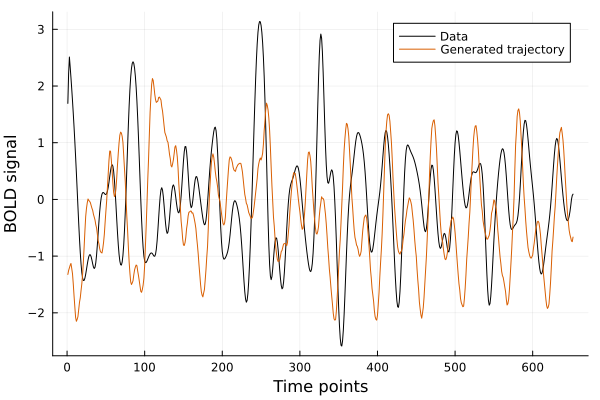

In [5]:
#Plotting
dim = 5
plot(X_total[:, dim], label="Data", color = :black)
plot!(X_gen[:, dim], label = "Generated trajectory", color="#d95f02")
plot!(ylabel="BOLD signal", xlabel="Time points")

In [6]:
#compute measures
measure_settings = Dict("Dstsp" => 1.0f0, "PSE" => 1.0f0, "PE" => 10)
# dstsp
Dstsp = state_space_distance(X_total, X_gen, measure_settings["Dstsp"])
# pse
PSE, _ = power_spectrum_error(X_total, X_gen, measure_settings["PSE"])
# PE
PE, PE_test = prediction_error(dataset, model, O, measure_settings["PE"])

(0.3516058f0, 2.139583f0)